## Deep Learning with Python (DLPy) and SAS Viya: Survival Analysis

The following example uses SAS DLPy to illustrate how we can easily apply a deep learning model for survival analysis through [the employee attrition data set](https://github.com/square/pysurvival/blob/master/pysurvival/datasets/employee_attrition.csv)  from [PySurvival](https://square.github.io/pysurvival/index.html). The analysis is to predict when an employee quit his job and understand the risk factors for employee turnover. This example demonstrates that the deep survival model can achieve better prediction than the popular Cox proportional hazards model.

# Table of contents
1. [Survival Analysis and Censoring](#introduction)
2. [Employee Attrition Data](#EDA)
3. [Prepare the Data](#prepare)
3. [Deep Survival Model for Employee Churn Analysis](#build_deepsurv)
    1. [Build a Deep Learning Model with Survival Loss](#model_specification)
    2. [Train a Deep Learning Model](#model_training)
    3. [Build a Cox Proportional Hazard Model](#build-cox)
    4. [Train a Cox Proportional Hazard Model](#train-cox)
4. [Model Performance and Predictions](#evaluation)
    1. [Compare the Models](#compare-models)
    2. [Understand the Predictions from the Models](#understand-models)
    3. [Predict High-Risk Employees](#predict-employees)
    4. [Predict When an Employee Will Leave](#predict-time)
    5. [Identify and Understand Risk Factors](#predict-risk)
5. [Summary](#summary)

## 1. Survival Analysis and Censoring <a name="introduction"></a>

[Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis) is widely used for analyzing life time data, where the target variable is the  duration/survival time until an event of interest occurs. One of the goals in survival analysis is to predict when an event of interest is likely to happen.

Survival analysis can be applied on many areas:

- Medical research: predict survival time after treatment
- Finance industry: predict when a borrower will likely to repay loan (credit risk)
- Churn analysis: understand why and when clients unsubscribe or stop their services
- Manufacturers: predict when an electronic device will break

What is censoring and why does it matter?
- Censoring happens if an individual doesn't experience the event of interest during the study period. In this situation, the individual's survival time is censored and not fully observed. In the employee attrition example, if an employee still works in the company by the time of collecting the data, the employee's tenure time is censored.
- Standard regression models without accounting for censoring appropriately often lead to less accurate prediction and invalid inference. Therefore, survival models are developed to account for censoring, which can often lead to better prediction and valid inference.

### Load packages and launch CAS
Be sure to change **your_host_name** and **your_port_number**.

In [1]:
from swat import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.model_selection import train_test_split
import warnings
%matplotlib inline

import dlpy
from dlpy.layers import *
from dlpy.model import *
from dlpy.images import ImageTable
from dlpy.sequential import Sequential
from dlpy.lr_scheduler import *

In [2]:
# Start a CAS session
host_name='cloud.example.com'
port_number='5570'
s = CAS(host_name, port_number)

## 2. The Employee Attrition Data <a name="EDA"></a>
You can find [the employee attrition data set](https://github.com/square/pysurvival/blob/master/pysurvival/datasets/employee_attrition.csv)  from [PySurvival](https://square.github.io/pysurvival/index.html). Because it is a fairly small data set we can do some preliminary exploratory data analysis using DataFrames.

In [3]:
df_employee = pd.read_csv(r"/path/to/data/employee_attrition.csv")
print("Size of the data set:", df_employee.shape)
df_employee.head()

Size of the data set: (14999, 10)


,satisfaction_level,last_evaluation,number_projects,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


###  2.1 Target variable and its distribution
The target variable is "time_spend_company" which indicates the time that an employee spent at the company.

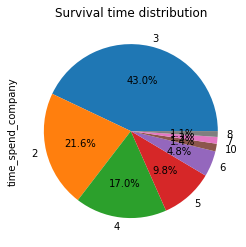

In [4]:
time_column = 'time_spend_company'
df_employee[time_column].value_counts().plot(kind='pie', autopct='%1.1f%%').set_title('Survival time distribution')
plt.show()

### 2.2 Censoring indicator variable: left
The other main variable of interest is "left", which indicates whether or not an employee left (i.e. quit, retired, etc.) during the study. If the employee left then the data is censored. The variable is encoded as follows:
* 1: indicates that an employee left the company, so his/her duration time at the company is completely observed.
* 0: indicates that an employee is still working in the company during the time of the study, so his/her duration time at the company is incompletely observed and censored.

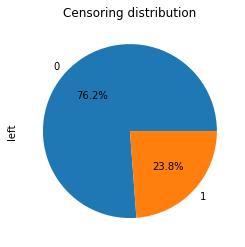

In [5]:
event_column = 'left'
df_employee[event_column].value_counts().plot(kind='pie', autopct='%1.1f%%').set_title('Censoring distribution')
plt.show()

Note: In this data set, 76.2% observations have censored target values. Standard regression methods often lead to less accurate predictions, regardless of whether they ignore censoring information or drop censored observations.

### 2.3 Input features

The main input features we are interested in is "satisfaction_level" which describes employee satisfaction as reported by self evaluation. Values range from 0 to 1 with 0 indicating totally dissatisfied and 1 indicating totally satisfied.

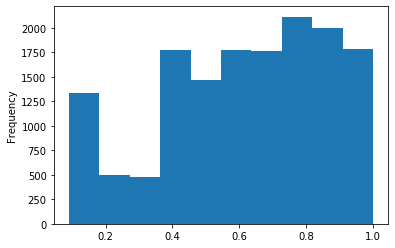

In [6]:
df_employee['satisfaction_level'].plot.hist(legend=None)
plt.show()

## 3. Prepare data for survival analysis <a id="prepare"></a>

### 3.1 Split data into training and test data
We split the dataset to train (70% samples) and test (30% samples), creating DataFrames dl_train and dl_test, respectively.

In [7]:
N = df_employee.shape[0]
seed = 61386
index_train, index_test = train_test_split(range(N), test_size=0.3,random_state=seed)

dl_train = df_employee.loc[index_train].reset_index(drop=True)
dl_test  = df_employee.loc[index_test].reset_index(drop=True)

### 3.2 Prepare a target variable y for survival analysis
Target variable y is obtained by combining censoring information and original target values (time_spend_company). Negative numbers denote censored information. More specifically:
-  y =   time_spend_company if left = 1 when an employee left the company
-  y = -1*time_spend_company if left = 0 when an employee didn't leave the company

In [8]:
dl_train['y'] = dl_train.apply(lambda row: (row[time_column] if row[event_column] else -row[time_column]), axis=1)
dl_test['y']  = dl_test.apply(lambda row: (row[time_column] if row[event_column] else -row[time_column]), axis=1)

### 3.3 Create ID Variable and Load DataFrames into CAS
We create an ID variable in dl_train and dl_test. Then we upload the DataFrames into CAS in two steps. First, we create trainTbl and testTbl as CASTable objects. Note, however, that neither definition refers to the DataFrames we've been working with. The next step takes those DataFrames and uses `CAS.upload_frame()` in order to upload them to the CAS server and identify the resulting in-memory tables with trainTbl and testTbl.

For efficiency, we specify `type='char'` for both department and salary. The default value is varchar.

In [9]:
# dl_train['id'] = np.arange(dl_train.shape[0])
dl_test['id'] = np.arange(dl_test.shape[0])

trainTbl = s.CASTable("train",replace=True)
testTbl = s.CASTable("test",replace=True)

CAS.upload_frame(s, 
                 dl_train,  
                 casout=trainTbl,
                 importoptions=dict(vars=dict(department=dict(type='char',length='11'), 
                                              salary=dict(type='char',length='6'))))
CAS.upload_frame(s, 
                 dl_test,  
                 casout=testTbl,
                 importoptions=dict(vars=dict(department=dict(type='char',length='11'), 
                                              salary=dict(type='char',length='6'))))

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSER(user).
NOTE: The table TRAIN has been created in caslib CASUSER(user) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table TEST in caslib CASUSER(user).
NOTE: The table TEST has been created in caslib CASUSER(user) from binary data uploaded to Cloud Analytic Services.


CASTable('TEST', caslib='CASUSER(user)')

### 3.4 Verify Data Sets After Split
Finally, we ensure that the data split as we were expecting at 70% training and 30% testing.

In [10]:
splitRatio = trainTbl.shape[0]/(trainTbl.shape[0]+testTbl.shape[0])
train_string = "Size of training data: {}.  {:.1%} samples"
test_string = "Size of test data: {}.  {:.1%} samples"  
print(train_string.format(trainTbl.shape, splitRatio)) 
print(test_string.format(testTbl.shape, 1-splitRatio)) 

Size of training data: (10499, 11).  70.0% samples
Size of test data: (4500, 12).  30.0% samples


## 4 Deep Survival Model for Employee Attrition Analysis <a name="build_deepsurv"></a>
In this section, we create and train a Deep Survival model. To compare results, we also build and train a Cox Proportional Hazards model.

### 4.1 Specify inputs and target variables
We prepare the input and target variables by taking advantage of some properties of sets in Python. We create inputs as a set containing all the columns of trainTbl. Then, we use "subtraction" to exclude the target and censoring variables. Namely, we exclude y, time_column (alias of time_spend_company), and event_column (alias of left). We cast the results back to a list and overwrite the inputs variable and print a summary of the input variables.

Note that we are using y as the target variable, not the time spent at the company. This allows us to simultaneously predict whether or not the employee left (based on sign) along with the time the employee spent at the compnay (based on magnitude).

In [11]:
print("Prepare input and target variables")
inputs = set(trainTbl.columninfo()["ColumnInfo"]["Column"])
inputs = list(inputs -{'y',time_column,event_column}) 

print("Number of input variables:", len(inputs))
print("\nInput variables:\n", inputs)
nominals = ["department","salary"]
print("\nNominal inputs:", nominals)
print("\nTarget variable:","y") 

Prepare input and target variables
Number of input variables: 8

Input variables:
 ['work_accident', 'promotion_last_5years', 'department', 'last_evaluation', 'satisfaction_level', 'average_montly_hours', 'salary', 'number_projects']

Nominal inputs: ['department', 'salary']

Target variable: y


### 4.2 Build a deep survival model<a name="model_specification"></a>
- The [deep survival model](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1) builds on the classical proportional hazards model, and use deep learning as backbone to automatically learn a flexible and complex hazard function, which can improve model prediction.
- You can refer to the paper ["DeepSurv: Personalized Treatment Recommender System Using A Cox Proportional Hazards Deep Neural Network"](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1) for details.

We build the model layer by layer using DLPy's Sequential API. Because we are predicting a single target (y), the final fully connected layer should consist of a single neuron with an identity activation function. Finally, the task-specific Survival layer is added to obtain the survival loss function. 

The prediction from the Deep Survival Model is the risk score: $e^{h(x)}$, which is an important element of the hazard function.

In [12]:
modelName='deepsurv_model';

inputVars = inputs
print("Input vars:",inputVars)
nInput= len(inputVars)
print("Number of inputs:",nInput)
nHidden = nInput + 5
print("Number of hidden units:",nHidden)
deepSurvModel = Sequential(s, model_table=modelName)
deepSurvModel.add(InputLayer(std='STD'))
deepSurvModel.add(Dense(n=nHidden, act='identity', include_bias=False))
deepSurvModel.add(BN(act='relu'))
deepSurvModel.add(Dense(n=nHidden, act='identity', include_bias=False))
deepSurvModel.add(BN(act='relu'))
deepSurvModel.add(Dense(n=1, act='identity'))
deepSurvModel.add(Survival())

Input vars: ['work_accident', 'promotion_last_5years', 'department', 'last_evaluation', 'satisfaction_level', 'average_montly_hours', 'salary', 'number_projects']
Number of inputs: 8
Number of hidden units: 13
NOTE: Input layer added.
NOTE: Fully-connected layer added.
NOTE: Batch normalization layer added.
NOTE: Fully-connected layer added.
NOTE: Batch normalization layer added.
NOTE: Fully-connected layer added.
NOTE: Survival layer added.
NOTE: Model compiled successfully.


In [13]:
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,TRAIN,10499,11,0,utf-8,2020-03-19T14:03:33-04:00,2020-03-19T14:03:33-04:00,2020-03-19T14:03:35-04:00,UTF8,1.900260e+09,...,0,0,0,,,0,user,,2020-03-19T14:03:33-04:00,1.900260e+09
1,TEST,4500,12,0,utf-8,2020-03-19T14:03:33-04:00,2020-03-19T14:03:33-04:00,2020-03-19T14:03:35-04:00,UTF8,1.900260e+09,...,0,0,0,,,0,user,,2020-03-19T14:03:33-04:00,1.900260e+09
2,DEEPSURV_MODEL,53,5,0,utf-8,2020-03-19T14:03:37-04:00,2020-03-19T14:03:37-04:00,2020-03-19T14:03:37-04:00,UTF8,1.900260e+09,...,0,0,0,,,0,user,,,NaN


#### Plot deep survival model architecture

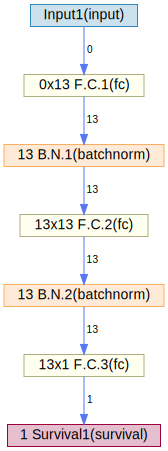

In [14]:
deepSurvModel.plot_network()

In [15]:
deepSurvModel.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,Input1,input,,,None,0,"(0, 0)",0
1,1,F.C.1,fc,"(0, 13)",,Identity,13,"(0, 0)",0
2,2,B.N.1,batchnorm,,,Relu,13,"(0, 2)",0
3,3,F.C.2,fc,"(13, 13)",,Identity,13,"(169, 0)",169
4,4,B.N.2,batchnorm,,,Relu,13,"(0, 2)",0
5,5,F.C.3,fc,"(13, 1)",,Identity,1,"(13, 0)",13
6,6,Survival1,survival,,,None,1,"(0, 0)",0
7,,,,,,,,Total number of parameters,Total FLOPS
8,Summary,,,,,,,186,182


### 4.3 Train deep survival model <a name="model_training"></a>

#### Specify  the momentum SGD optimizer and a learning rate scheduler

In [16]:
lr_scheduler = ReduceLROnPlateau(conn=s, cool_down_iters=3, gamma=0.8, learning_rate=0.001, patience=5)
solver = MomentumSolver(lr_scheduler=lr_scheduler,
                        momentum=0.9,
                        clip_grad_max = 100,
                        clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=400, log_level=2, max_epochs=100, reg_l2=0.001)

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


####  Train deep survival model with momentum SGD

In [17]:
print(deepSurvModel.model_name)
deepsurvTrain_res = deepSurvModel.fit(data=trainTbl,
                                      data_specs=[dict(layer='input1',type='numnom', data=inputVars,nominals=nominals),
                                                  dict(layer='survival1',type='numnom',data='y')],
                                      n_threads= 2,
                                      record_seed=13309,
                                      optimizer=optimizer)

deepsurv_model
NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 482.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.07 (s).
NOTE:  The total number of threads on each worker is 2.
NOTE:  The total mini-batch size per thread on each worker is 400.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 800.
NOTE:  Target variable: y
NOTE:  Number of input variables:     8
NOTE:  Number of nominal input variables:      2
NOTE:  Number of numeric input variables:      6
NOTE:  Epoch Learning Rate        Loss   Time(s)
NOTE:  0         0.001           1.086     0.10
NOTE:  1         0.001           1.116     0.10
NOTE:  2         0.001           1.139     0.10
NOTE:  3         0.001            1.08     0.10
NOTE:  4         0.001           1.084     0.10
NOTE:  5         0.001           1.085     0.10
NOTE:  6         0.0

#### Visualize training loss history to check model convergence

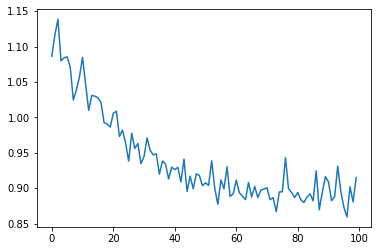

In [18]:
plt.plot(deepsurvTrain_res["OptIterHistory"][["Loss"]])

### 4.4 Build [Cox proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model) <a id="build-cox"></a>
The Cox proportional hazards model is of the same form, except the risk score function is not estimated by a neural network. Instead, linear features are used. Thus, we can model the Cox proportional hazards model using a neural network with a single dense layer with identity activation function then feeding the results into the Survival layer.

In [19]:
modelName='cox_model';
coxModel = Sequential(s, model_table=modelName)
coxModel.add(InputLayer(std='STD'))
coxModel.add(Dense(n=1, act='identity', include_bias=False))
coxModel.add(Survival())

NOTE: Input layer added.
NOTE: Fully-connected layer added.
NOTE: Survival layer added.
NOTE: Model compiled successfully.


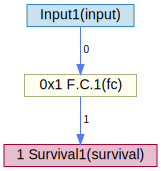

In [20]:
coxModel.plot_network()

In [21]:
coxModel.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,Input1,input,,,None,0,"(0, 0)",0
1,1,F.C.1,fc,"(0, 1)",,Identity,1,"(0, 0)",0
2,2,Survival1,survival,,,None,1,"(0, 0)",0
3,,,,,,,,Total number of parameters,Total FLOPS
4,Summary,,,,,,,0,0


### 4.5 Train Cox model <a id="train-cox">
For a more accurate comparison of models, we make sure to use the same optimizer and record_seed as the Cox deep survival model.

In [22]:
print(coxModel.model_name)
coxTrain_res = coxModel.fit(data=trainTbl,
                            data_specs=[dict(layer='input1', type='numnom', data=(inputVars), nominals=nominals),
                                        dict(layer='survival1', type='numnom', data='y')],
                            n_threads= 2,
                            record_seed=13309,
                            optimizer=optimizer)

cox_model
NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 19.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.07 (s).
NOTE:  The total number of threads on each worker is 2.
NOTE:  The total mini-batch size per thread on each worker is 400.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 800.
NOTE:  Target variable: y
NOTE:  Number of input variables:     8
NOTE:  Number of nominal input variables:      2
NOTE:  Number of numeric input variables:      6
NOTE:  Epoch Learning Rate        Loss   Time(s)
NOTE:  0         0.001           1.077     0.07
NOTE:  1         0.001           1.119     0.07
NOTE:  2         0.001           1.158     0.07
NOTE:  3         0.001           1.104     0.07
NOTE:  4         0.001            1.11     0.07
NOTE:  5         0.001           1.124     0.07
NOTE:  6         0.001    

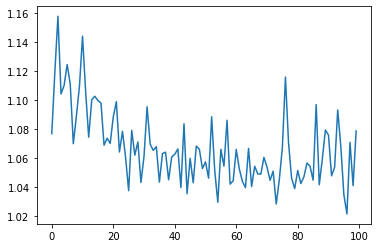

In [23]:
plt.plot(coxTrain_res["OptIterHistory"][["Loss"]])
plt.show()

## 5. Model Performance and Predictions <a name="evaluation"></a> 
This section compares the deep survival model performance against the Cox proportional hazards model performance, shows how to identify at-risk employees, and shows how to calculate a survival function for each employee. Further, it shows a comparison of employees from a high risk group and a low risk group and looks into factors that could contribute to employee turnover.

### 5.1 Overall model predictive performance in terms of C-Index on test data <a id="compare-models"></a>

- C-index (Concordance index) is a commonly used metric to evaluate and compare survival model's discriminative power.
- It is calculated as the fraction of pairs of observations whose observed and predicted outcomes agree among all possible pairs. That is, the longer the observed survival time is, the higher the predicted survival probability is.
- The higher the C-index is, the better the model is.

#### C-Index for Cox survival model
To determine the C-index, we use `model.predict` with parameter `log_level=4`. The C-Index is reported in the log.

In [24]:
coxModel.predict(testTbl,buffer_size=10000,log_level=4)

NOTE: Due to data distribution, miniBatchSize has been limited to 146.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.03 (s).
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s) (Validation)
NOTE:      0  4500        0           0.8352     0.8411  1.737e+06  3.281e+05          0     0.01


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          4500
 1  Number of Observations Used          4500
 2                   Loss Error      0.835209

[CumHazard]

    Time    CumHaz
 0   2.0  0.002548
 1   3.0  0.103708
 2   4.0  0.232851
 3   5.0  0.506593
 4   6.0  0.651181

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(user)  Valid_Res_dPTVAH  4500       13   
 
                                             casTable  
 0  CASTable('Valid_Res_dPTVAH', caslib='CASUSER(k...  

+ Elapsed: 0.175s, user: 0.325s, sys: 0.054s, mem: 73.5mb

#### C-Index for deep survival model

In [25]:
deepSurvModel.predict(testTbl,buffer_size=10000,log_level=4)

NOTE: Due to data distribution, miniBatchSize has been limited to 146.
NOTE:  Loading weights cost       0.01 (s).
NOTE:  Initializing each layer cost       0.03 (s).
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s) (Validation)
NOTE:      0  4500        0           0.6615     0.9272  1.915e+06  1.503e+05          0     0.02


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          4500
 1  Number of Observations Used          4500
 2                   Loss Error      0.661458

[CumHazard]

    Time    CumHaz
 0   2.0  0.000719
 1   3.0  0.025542
 2   4.0  0.096010
 3   5.0  0.282016
 4   6.0  0.417285

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(user)  Valid_Res_PfSzOm  4500       13   
 
                                             casTable  
 0  CASTable('Valid_Res_PfSzOm', caslib='CASUSER(k...  

+ Elapsed: 0.179s, user: 0.351s, sys: 0.056s, mem: 74.2mb

### <center> Comparison of model predictive performance on test data in terms of C-Index</center>
| Model | C-Index |
| --- | --- | 
| Cox Model | 0.85 |
| Deep Survival Model | 0.92 |

The summary table above shows that the deep survival model provides more accurate prediction than the Cox model in terms of C-Index.

### 5.2 Understand the prediction from the survival models <a id="understand-models"></a>
Both the deep survival model and the Cox proportion model assume that 
the [hazard function](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function) for an individual with input $x$ is a product of two components:
$$\lambda(t | x) = \lambda_{0}(t)  e^{h(x)},$$
where $λ_0(t)$ is a baseline hazard function, and $r(x)=e^{h(x)}$ is a risk score.

Since the  baseline hazard function $λ_0(t)$ is the same for all individuals, a higher risk score $r(x)$ leads to a higher hazard rate $\lambda(t | x)$.

The prediction from deep survival models is the risk score.

### 5.3 Predict the employees who are likely to quit: <a id="predict-employees"><a>

After we train a deep survival model, we can use the model to predict risk scores. The risk scores can help predict the employees who are likely quit.

This occurs in three steps:
1. Obtain the baseline cumulative hazard function
2. Predict the hazard scores
3. Identify high-risk individuals

#### Step One: Obtain the baseline cumulative hazard function

In [26]:
surv_model = deepSurvModel
score_trainTbl = surv_model.predict(trainTbl)
print(score_trainTbl)

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read         10499
 1  Number of Observations Used         10499
 2                   Loss Error      0.152909

[CumHazard]

    Time    CumHaz
 0   2.0  0.000794
 1   3.0  0.025031
 2   4.0  0.101891
 3   5.0  0.289503
 4   6.0  0.420494

[OutputCasTables]

             casLib              Name   Rows  Columns  \
 0  CASUSER(user)  Valid_Res_PfSzOm  10499       12   
 
                                             casTable  
 0  CASTable('Valid_Res_PfSzOm', caslib='CASUSER(k...  

+ Elapsed: 0.201s, user: 0.572s, sys: 0.066s, mem: 73.8mb


#### Step Two: Predict Hazard Scores
The predicted hazard scores are reported in the table as \_DL_Pred_.

In [27]:
surv_model.predict(testTbl)
predicted_hazard  = surv_model.valid_res_tbl
predicted_hazard.head()

,satisfaction_level,last_evaluation,number_projects,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary,y,id,_DL_Pred_
0,0.15,0.74,6.0,144.0,7.0,0.0,0.0,1.0,management,high,-7.0,0.0,0.383156
1,0.09,0.83,6.0,282.0,4.0,0.0,1.0,0.0,technical,medium,4.0,1.0,5.933495
2,0.45,0.46,2.0,130.0,3.0,0.0,1.0,0.0,technical,low,3.0,2.0,34.926479
3,0.46,0.55,2.0,145.0,3.0,0.0,1.0,0.0,technical,low,3.0,3.0,26.362024
4,0.45,0.87,2.0,268.0,4.0,1.0,0.0,0.0,IT,low,-4.0,4.0,0.447191


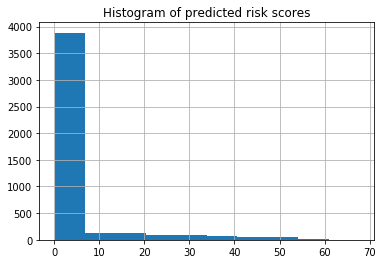

In [28]:
predicted_hazard["_DL_Pred_"].hist(bins=10)
plt.title("Histogram of predicted risk scores")
plt.show()

#### Step Three: Identify high-risk individuals
Employees can be classified into two groups in terms of predicted risk scores:
1. High risk group with score>10 and low risk group with score<10. 
2. Employees in the high risk group are more likely quit than those in the low risk group

In [30]:
df_hazard = predicted_hazard.to_frame()
risk_cutoff = 10
riskGroup = {"low risk":(df_hazard[df_hazard._DL_Pred_<risk_cutoff].id).reset_index(drop=True),
             "high risk": df_hazard[df_hazard._DL_Pred_>risk_cutoff].id.reset_index(drop=True)}
low = riskGroup["low risk"]
df_low = (df_hazard.loc[df_hazard["id"].isin(low)])
# employees who left the company
df_low = df_low[df_low.left==1]

high = riskGroup["high risk"]
df_high = (df_hazard.loc[df_hazard["id"].isin(high)])
df_high = df_high[df_high.left==1] # employees who left the company
id = [df_low.id.iloc[1],df_high.id.iloc[1]] ##
print("An employee's id from the low risk group in the test data set: {}".format(int(id[0])))
print("An employee's id from the high risk group in the test data set: {}".format(int(id[1])))

An employee's id from the low risk group in the test data set: 6
An employee's id from the high risk group in the test data set: 3


### 5.4 Predict when an employee is likely to quit using the predicted survival function <a id="predict-time">
We can use the predicted survival function to tell *when* an employee is likely to quit. The survival function for given an individual can be obtained as follows:
- Step 1. We score with the training data set to obtain the baseline cumulative hazards
- Step 2. We score with the testing data set to get the hazard score of individuals
- Step 3. We multiply the baseline hazard function and the risk score to obtain the survival function for individuals

The survival function indicates the probability an employee will remain at the company at time t.

#### Helper Functions
Before we analyze the employee data, we will define two functions: one to help compute the survival functions and one to help visualize them. 

#### Helper Function to Compute Survival Function
The function `dl_survival_function` computes a DataFrame that has a survival function for each employee. To compute this, it needs two DataFrames as input. One DataFrame must have the baseline cumulative hazard function. We can obtain this from the CumHaz key of the CASResult object returned from the `predict` method. The other DataFrame needs individual employee information and employee risk scores. When we invoke the `predict` method, this information is stored as a CASTable in `model.valid_res_tbl`. Since the data set is small, we can cast this as a DataFrame and use it in `dl_survival_function`.


Note that for real data, we will not have target information for "test" data, but we will for the data we train our model on. Therefore, we will get the baseline cumulative hazard function from the training data set, but still use the risk scores from the testing data set.

Note also, that we have already scored the test table and stored the results as `predicted_hazard  = surv_model.valid_res_tbl`.

In [31]:
def dl_survival_function(df_baselineCumHazard, df_hazard, id=None):
    if not isinstance(df_baselineCumHazard, SASDataFrame) and not isinstance(df_hazard, pd.DataFrame):
        raise TypeError("inputs must be data frame!")

    # Create survival (DataFrame); calculate s (survival function) from baseline cumulative hazard.
    survival = pd.DataFrame()
    survival["Time"] = df_baselineCumHazard["Time"]
    s = np.outer(-1*df_baselineCumHazard["CumHaz"],df_hazard["_DL_Pred_"])
    s = np.exp(s)

    if isinstance(id, str):   
        idColumns = [id+'='+str(v) for v in df_hazard[id]]
        s = pd.DataFrame(s,columns=idColumns)
    else:
        s = pd.DataFrame(s)             
    survival = pd.concat([survival, s], axis=1)
    return survival          

#### Helper Function to Plot Survival Function
The function `plot_survival` requires as argument, the survival DataFrame we just created, and a DataFrame with employee hazard information. The function plots survival rate as a function of time for two employees. Hazard information is used to classify the employees into high risk and low risk. The function ensures that one employee from each classification group is chosen.

In [32]:
def plot_survival(survival, hazard_df, modelName=None, id=None):
    
    colors=['red','blue']
    if id is None:
        id=[0,1]  
        
    eventTimes = list(df_hazard[hazard_df.id==id[0]].time_spend_company) + list(hazard_df[hazard_df.id==id[1]].time_spend_company)

    print("Time spent in company for two employees:{} and {}".format(int(eventTimes[0]),int(eventTimes[1])))
    predHazard = list(hazard_df[hazard_df.id==id[0]]._DL_Pred_) +  list(hazard_df[hazard_df.id==id[1]]._DL_Pred_)
    
    print("Predicted hazards for two employees:",predHazard)    
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.plot(survival.Time, survival[id[0]],color=colors[0],label='low risk')
    plt.plot(survival.Time, survival[id[1]],color=colors[1],label='high risk')
    # Actual time
    plt.axvline(x=eventTimes[0],  color=colors[0], ls ='--')
    plt.axvline(x=eventTimes[1],  color=colors[1], ls ='--')
    i=0
    ax.annotate('T={:.1f}'.format(eventTimes[0]), xy=(eventTimes[0], 0.5*(1.+0.2*i)),
            xytext=(eventTimes[0], 0.5*(1.+0.2*i)), fontsize=12)
    i=1
    ax.annotate('T={:.1f}'.format(eventTimes[1]), xy=(eventTimes[1], 0.5*(1.+0.2*i)),
            xytext=(eventTimes[1], 0.5*(1.+0.2*i)), fontsize=12)

    title = "Comparing survival functions from {} groups".format("low risk and high risk")
    if isinstance(modelName, str):
        title = modelName + ": " + title
    plt.legend(fontsize=12)
    plt.title(title, fontsize=15)
    plt.ylabel("Survival probability")
    plt.xlabel("Time spent in the company")    
    plt.ylim(0, 1.05)
    plt.show()
    return

#### Predicting Survival Functions for All Employees
Step One: Calculate the baseline cumulative hazard function from the training data set

In [33]:
df_hazard = predicted_hazard.to_frame()
df_baselineCum_hazard= pd.DataFrame(score_trainTbl["CumHazard"])

Step 2: Calculate survival function from training set; id is for risk groups based on deep learning model

In [34]:
dl_survival = dl_survival_function(df_baselineCum_hazard, df_hazard, id=None)

#### Plotting Survival Functions for Employees in Different Risk Groups

Time spent in company for two employees:5 and 3
Predicted hazards for two employees: [0.808940589427948, 26.362024307250977]


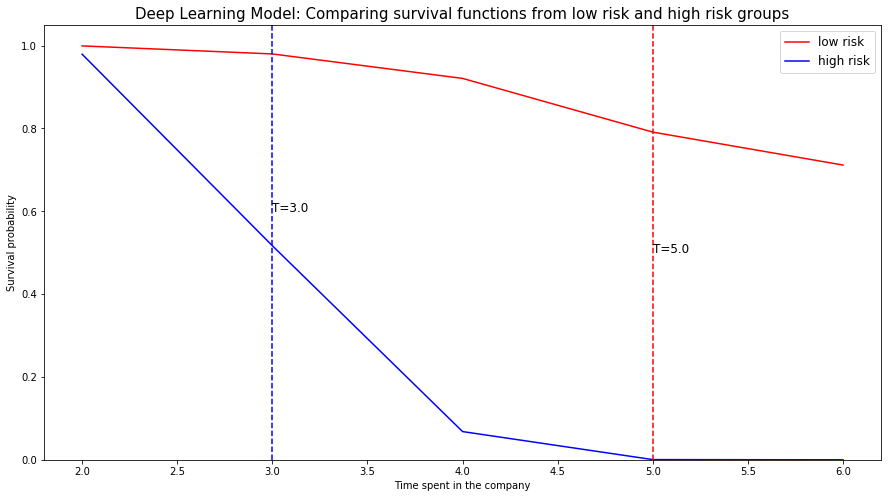

In [35]:
plot_survival(dl_survival, df_hazard, modelName="Deep Learning Model",id=id)

- As we expect, the predicted survival curve for the employee with low risk is above the one with hight risk, since the employee from the high risk group has higher hazard rate than the employee from the low risk group.
- From the survival function of the employee from the high risk group, we can tell that the employee spent at this company more than 3 years with the probability around 0.5. And from the test data set, we knew that the employee's tenure time at the company was 3 years.

### 5.5 Identify and Understand Risk Factors that Contribute to Employee Attrition <a id="predict-risk">
In this section, we will find how an employee's satisfaction_level impacts his or her time spent at the company.

#### Prepare Input Data to Predict Survival Probability Curves

In [36]:
inputTbl = s.CASTable("input", replace=True)
employee_id = df_high.id.iloc[1]
s.runCode(code="""data {0};
                   set {1};
                   array level(3)  _temporary_ (0.3 0.5 0.7) ;                    
                   if id={2} then do;
                        do i=1 to 3;
                            satisfaction_level = level[i];
                            output;
                        end;
                    end;
                   run ;
                   """.format(inputTbl.name, testTbl.name, employee_id))

[InputCasTables]

             casLib  Name  Rows  Columns  \
 0  CASUSER(user)  test  4500       12   
 
                                      casTable  
 0  CASTable('test', caslib='CASUSER(user)')  

[OutputCasTables]

             casLib   Name  Rows  Columns  Append Promoted  \
 0  CASUSER(user)  input     3       13     NaN        N   
 
                                       casTable  
 0  CASTable('input', caslib='CASUSER(user)')  

+ Elapsed: 0.132s, user: 0.205s, sys: 0.055s, mem: 21.2mb

#### View Input Data

In [37]:
inputTbl.head()

,satisfaction_level,last_evaluation,number_projects,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary,y,id,i
0,0.3,0.55,2.0,145.0,3.0,0.0,1.0,0.0,technical,low,3.0,3.0,1.0
1,0.5,0.55,2.0,145.0,3.0,0.0,1.0,0.0,technical,low,3.0,3.0,2.0
2,0.7,0.55,2.0,145.0,3.0,0.0,1.0,0.0,technical,low,3.0,3.0,3.0


#### Predict Survival Rates

Step One: Obtain cumulative hazard estimates from the training data.

In [38]:
surv_model = deepSurvModel
#surv_model = CoxModel
score_trainTbl = surv_model.predict(trainTbl)
print(score_trainTbl)

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read         10499
 1  Number of Observations Used         10499
 2                   Loss Error      0.152909

[CumHazard]

    Time    CumHaz
 0   2.0  0.000794
 1   3.0  0.025031
 2   4.0  0.101891
 3   5.0  0.289503
 4   6.0  0.420494

[OutputCasTables]

             casLib              Name   Rows  Columns  \
 0  CASUSER(user)  Valid_Res_PfSzOm  10499       12   
 
                                             casTable  
 0  CASTable('Valid_Res_PfSzOm', caslib='CASUSER(k...  

+ Elapsed: 0.204s, user: 0.597s, sys: 0.042s, mem: 73.8mb


Step Two: Predict risk scores for each observation in the input table.

In [39]:
surv_model.predict(inputTbl)
predicted_hazard  = surv_model.valid_res_tbl
print("\n Predicted hazard scores:")
predicted_hazard.head()

NOTE: Due to data distribution, miniBatchSize has been limited to 3.

 Predicted hazard scores:


,satisfaction_level,last_evaluation,number_projects,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary,y,id,i,_DL_Pred_
0,0.3,0.55,2.0,145.0,3.0,0.0,1.0,0.0,technical,low,3.0,3.0,1.0,64.111519
1,0.5,0.55,2.0,145.0,3.0,0.0,1.0,0.0,technical,low,3.0,3.0,2.0,20.492044
2,0.7,0.55,2.0,145.0,3.0,0.0,1.0,0.0,technical,low,3.0,3.0,3.0,5.815919


Step Three: Combine baseline hazard rate and risk scores to compute survival function.

In [40]:
hazard_df = predicted_hazard.to_frame()
baselineCumHazard_df= pd.DataFrame(score_trainTbl["CumHazard"])
dl_survival = dl_survival_function(baselineCumHazard_df,hazard_df, id="id")

#### Plot predicted survival function on various satisfaction levels

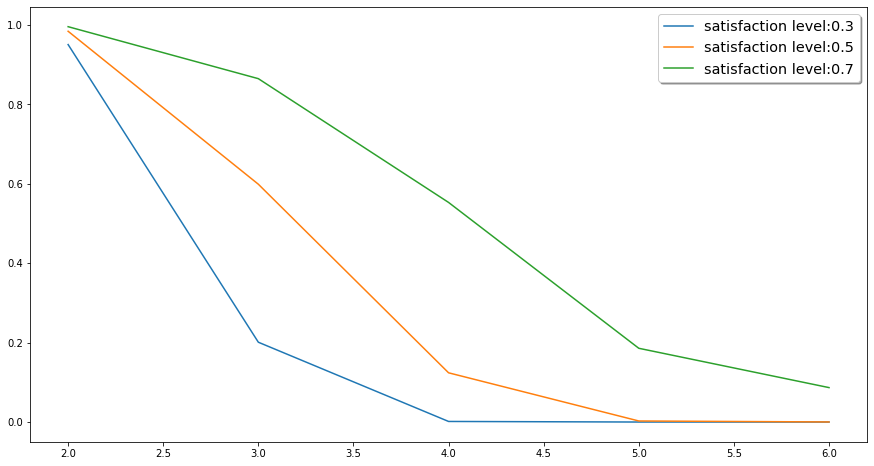

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(dl_survival.iloc[:,0], dl_survival.iloc[:,1],label='satisfaction level:0.3')
ax.plot(dl_survival.iloc[:,0], dl_survival.iloc[:,2],label='satisfaction level:0.5')
ax.plot(dl_survival.iloc[:,0], dl_survival.iloc[:,3],label='satisfaction level:0.7')
legend = ax.legend(shadow=True, fontsize='x-large')
plt.show()

* The survival functions  for various satisfaction levels in the plot show that the employee's satisfaction level has positive relationship with the employee' tenure time in this company.

### 6. Summary <a name="summary"></a> 

Survival analysis provides a valid and powerful way to analyze survival data with censoring. In the employee attrition analysis, the deep survival model can automatically learn a complex and nonlinear function to predict an employee's turnover risk, and perform better than the popular Cox proportional hazards model.

### Reference

* [DeepSurv: personalized treatment recommender system using a Cox proportional hazards deep neural network](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1)
* [PySurvival package for survival anlayis](https://square.github.io/pysurvival/index.html)
* [Employee Attrition Data Set from PySurvival](https://github.com/square/pysurvival/blob/master/pysurvival/datasets/employee_attrition.csv)
* [Knowing when your employees will quit](https://square.github.io/pysurvival/tutorials/employee_retention.html)
* [DeepHit: A Deep Learning Approach to Survival Analysis with Competing Risks](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit)
* [Cox Proportional Hazards Model](https://www.jstor.org/stable/pdf/2985181.pdf)
* [The PHREG Procedure from SAS](https://support.sas.com/documentation/onlinedoc/stat/141/phreg.pdf)
* [Telecoms Churn - Predicting Customer Turnover](https://rpubs.com/dmorgan26/telecomschurn)

### Close the Session to Free Resources

In [42]:
s.endsession()

+ Elapsed: 0.000346s, user: 0.001s, mem: 0.209mb